In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from functools import  total_ordering
import copy

def get_values(data):
    result = []
    for x in data:
        try:
            result.append(x.value)
        except:
            result.append(x)
    return result

def get_deltas(data):
    result = []
    for x in data:
        result.append(x.delta)
    return result

def kovar(x_data, y_data):
    x = np.array(x_data)
    y = np.array(y_data)
    return (x*y).mean() - x.mean() * y.mean()

def mnk_non_zero(x_data, y_data):
    x =  np.array(x_data)
    y = np.array(y_data)
    k = kovar(x, y) / kovar (x, x)
    b = y.mean()-k*x.mean()

    sigma_k = ((kovar(y, y)/kovar(x,x) - k**2) / (len(x)-2) )**0.5
    sigma_b = sigma_k * (x**2).mean()**0.5
    return (DData(k, sigma_k)), (DData(b, sigma_b))

def linearcalc(x, y, xmin = None, xmax = None):
    plt.grid(True)
    plt.plot(x, y, "o")
    k, b = mnk_non_zero(x, y)
    if(xmin == None):
        xmin = x.min().value
    if(xmax == None):
        xmax = x.max().value
    xl = np.array([xmin, xmax])
    plt.plot(xl, xl*k.value + b.value)
    print("k, b =", k, b)
    return k, b

def linearcalc_error(x, y, xmin = None, xmax = None, label = "None"):
    plt.grid(True)
    if(type(x[0]) == DData):
        x_value = x.apply(lambda x: x.value)
        x_error = x.apply(lambda x: x.delta)
    else:
        x_value = x
        x_error = [0]*len(x_value)
    if(type(y[0]) == DData):
        y_value = y.apply(lambda y: y.value)
        y_error = y.apply(lambda y: y.delta)
    else:
        y_value = y
        y_error = [0]*len(y_error)
    k, b = mnk_non_zero(x_value, y_value)

    if(xmin == None):
        xmin = x.min().value
    if(xmax == None):
        xmax = x.max().value
    xl = np.array([xmin, xmax])

    plt.errorbar(x = x_value, y = y_value, xerr=x_error, yerr=y_error, fmt = "o", ms = 1, label = label)
    
    xl = np.array([xmin-(xmax-xmin)*0.1, xmax +(xmax-xmin)*0.1])
    print(xl)
    plt.plot(xl, xl*k.value + b.value)
    print("k, b =", k, b)
    return k, b

class SerDData():
    """Запихиваешь сюда свою дату похожу на пандасовсвую серию и вызываешь ее параметры"""
    def __init__(self, data):
        try:
            self.data = pd.Series(data)
            self.data = self.data.dropna()
            #self.data = self.data.apply(SerDData.ConvertIfNotDData)
        except:
            raise Exception(f"Нифига не получилось. data = {data}")
        
    def ConvertIfNotDData(x):
        if(type(x) != DData):
            return DData(x)
    @property
    def sigmaRaspr(self):    
        mean = self.meanValue
        return (self.data.map(lambda x: (x.value - mean)**2).sum()/len(self.data))**0.5

    @property
    def meanValue(self):    
        return self.meanStupid.value

    @property
    def sigmaSluch(self):
        n = len(self.data)
        return(self.sigmaRaspr / (n*(n-1))**0.5)
    
    @property
    def sigmaPrib(self):
        return self.meanStupid.delta
    
    @property
    def meanStupid(self):
        result = self.data.sum()/len(self.data)
        result.delta *= (len(self.data))**0.5
        return(result)

    @property
    def mean(self):
        mean = self.meanStupid
        mean.delta = (mean.delta**2 + self.sigmaSluch**2)**0.5
        return mean

    @property
    def sigma(self):
        return self.mean.delta
    
@total_ordering
class DData():
    def __init__(self, value = 0, delta = 0, epsilon = 0, E = 0):
        self.__value = 0
        self.__delta = 0
        self.__E = E
        self.value = value
        assert (delta == 0 or epsilon == 0), "При задании можно указать только один тип погрешности"
        
        if(delta!=0):
            self.delta = delta
        elif(epsilon!=0):
            self.epsilon = epsilon
    
    @property
    def E(self):
        return self.__E
    
    @E.setter
    def E(self, value):
        self.value *= 10**(self.E-value)
        self.delta *= 10**(self.E-value)
        self.__E = value

    @property
    def value(self):
        return self.__value

    @value.setter
    def value(self, value):
        if(isinstance(value, DData)):
            self.__value = value.value
            self.__delta = value.delta
            self.__E = value.E
        elif(isinstance(value, (int, float))):
            self.__value = value 
        else:
            assert False, "Значение должно быть числом"

    @property
    def epsilon(self):
        if(self.value == 0):
            return 0
        return self.delta/self.value
    @epsilon.setter
    def epsilon(self, epsilon):
        self.delta = abs(self.value*epsilon)

    @property
    def delta(self):
        return self.__delta
    @delta.setter
    def delta(self, delta):
        self.__delta = delta

    def __str__(self):
        #return(f"{self.__value} \\pm {self.__delta}")
        return self.LaTeX()
    def to_str(self, LaTeX = False, E = False):
        try:
            if(self.delta != 0):
                znak = -int((np.log10(self.delta))//1)+1
            else:
                znak = 1
        except:
            warnings.warn(f"попытка вывести какую-то хрень. value = {self.value}, delta = {self.delta}")
            return "NaN"
        try:
            form = f".{znak}f"
            value_str = round(self.value, znak)

            delta_str = round(self.delta, znak)

            value_str = format(value_str, form)
            delta_str = format(delta_str, form)

            if LaTeX:
                return f"${value_str} \pm {delta_str}$"
            elif not E or self.E == 0:

                return (f"{value_str} \pm {delta_str}")
            else:
                return (f"{value_str} \pm {delta_str} \cdot 10^{E}")
        except:
            warnings.warn("Что-то сломалось при отображении ")
            return f"${round(self.value, znak)} \pm {round(self.delta, znak)}$"
    def __neg__(self):
        return DData(-self.value, self.delta, E = self.E)

    def __add__(self, other):
        other = DData(other)
        if(self.E == other.E):
            return(DData(self.value + other.value, (self.delta**2 + other.delta**2)**0.5, E = self.E))
        else:
            newE = min(self.E, other.E)
            other.E = newE
            newSelf = DData(self)
            newSelf.E = newE
            return(newSelf+other)
           
    def __radd__(self, other):
        return self + other

    def __sub__(self, other):
        return self + (-other)
    
    def __rsub__(self, other):
        return -(self - other)
    
    def __mul__(self, other):
        other = DData(other)
        return DData(self.value * other.value, epsilon=(self.epsilon**2 + other.epsilon**2)**0.5, E = self.E + other.E)
        
    def __rmul__(self, other):
        return self*other
        
    def __truediv__(self, other):
        if(isinstance(other, (int, float, DData))):
            other = DData(other)
            return DData(self.value / other.value, epsilon=(self.epsilon**2 + other.epsilon**2)**0.5, E = self.E - other.E)
        elif (isinstance(other, pd.Series)):
            return 1/other * self
        else:
            assert False, f"А фиг тебе, я не умею делить на {other} типа {type(other)}"
        
    def __rtruediv__(self, other):
        return (DData(1)/self) * other
    
    def __pow__(self, other):
        if(isinstance(other, (int, float))):
            return DData(self.value**other, epsilon=other*self.epsilon, E = self.E * other)
        else:
            assert False, "Пока можно возводить только в степень точного числа"
    
    def __eq__(self, other):
        if not(isinstance(other, DData)):
            other = DData(other)
        return (self.value == other.value) and (self.delta == other.delta)

    def __lt__(self, other):
        if not(isinstance(other, DData)):
            other = DData(other)
        return (self.value < other.value)

    def LaTeX(self):
        return self.to_str(True)
    
    def changeE(self, E):
        try:
            self.E = E
            return True
        except:
            return False

    @staticmethod
    def tryConvert(x, delta = 0, epsilon = 0, E = 0):
        try:
            if(pd.isna(x)):
                return x
            return DData(float(x), delta = delta, epsilon = epsilon, E = E)
        except:
            return x
    def changeEInSerias(series : pd.Series, E):
        series.dropna().apply(lambda x: x.changeE(E))
    def log(x):
        if not(isinstance(x, DData)):
            x = DData(x)
        return(DData(np.log(x.value), x.epsilon))
    



<>:205: SyntaxWarning: invalid escape sequence '\p'
<>:208: SyntaxWarning: invalid escape sequence '\p'
<>:210: SyntaxWarning: invalid escape sequence '\p'
<>:210: SyntaxWarning: invalid escape sequence '\c'
<>:213: SyntaxWarning: invalid escape sequence '\p'
<>:205: SyntaxWarning: invalid escape sequence '\p'
<>:208: SyntaxWarning: invalid escape sequence '\p'
<>:210: SyntaxWarning: invalid escape sequence '\p'
<>:210: SyntaxWarning: invalid escape sequence '\c'
<>:213: SyntaxWarning: invalid escape sequence '\p'
C:\Users\RedBrean\AppData\Local\Temp\ipykernel_1548\3699677873.py:205: SyntaxWarning: invalid escape sequence '\p'
  return f"${value_str} \pm {delta_str}$"
C:\Users\RedBrean\AppData\Local\Temp\ipykernel_1548\3699677873.py:208: SyntaxWarning: invalid escape sequence '\p'
  return (f"{value_str} \pm {delta_str}")
C:\Users\RedBrean\AppData\Local\Temp\ipykernel_1548\3699677873.py:210: SyntaxWarning: invalid escape sequence '\p'
  return (f"{value_str} \pm {delta_str} \cdot 10^{E

In [2]:
def T_UP(data : pd.DataFrame):
    up  = []
    for i in data.index:
        if(i == 0):
            up.append(True)
        elif(data["T"][i] > data["T"][i-1]):
            up.append(True)
        else:
            up.append(False)
    up = pd.Series(up)
    return data[up]

def T_DOWN(data : pd.DataFrame):
    up  = []
    for i in data.index:
        if(i == 0):
            up.append(False)
        elif(data["T"][i] > data["T"][i-1]):
            up.append(False)
        else:
            up[i-1] = True
            up.append(True)
    up = pd.Series(up)
    return data[up]

In [3]:
def calc_det(x : pd.Series, y : pd.Series):
    if(len(x) < 5):
        print("ERROR")
        return [0]*len(x)
    dets = [0]*len(x)
    for i in range(2, len(x)-2):
        x_srez = get_values(x)[i-2:i+3]
        y_srez = get_values(y)[i-2:i+3]
        k, _ = mnk_non_zero(x_srez, y_srez)
        try:
            k *= 10**(y[0].E-x[0].E)
            k.E = 0
        except:
            pass
        dets[i] = k
    dets[0], dets[1], dets[-1], dets[-2] = dets[2], dets[2], dets[-3], dets[-3]
    return (dets)


[<__main__.DData object at 0x0000020194407200>, <__main__.DData object at 0x0000020194407200>, <__main__.DData object at 0x0000020194407200>, <__main__.DData object at 0x0000020194407260>, <__main__.DData object at 0x00000201944072C0>, <__main__.DData object at 0x0000020194407320>, <__main__.DData object at 0x0000020194407380>, <__main__.DData object at 0x00000201944073E0>, <__main__.DData object at 0x0000020194407440>, <__main__.DData object at 0x00000201944074A0>, <__main__.DData object at 0x0000020194407500>, <__main__.DData object at 0x0000020194407500>, <__main__.DData object at 0x0000020194407500>]


,T0,h1,h2,T,h,P,k1,k2,L1,L2
0,27.00,$78.30 \pm 0.10$,$55.30 \pm 0.10$,$300.150 \pm 0.020$,$23.00 \pm 0.14$,$3.069 \pm 0.022$,$203 \pm 11$,$-5.26 \pm 0.25$,$2.76 \pm 0.15$,$2.43 \pm 0.11$
1,27.95,$78.80 \pm 0.10$,$55.10 \pm 0.10$,$301.100 \pm 0.020$,$23.70 \pm 0.14$,$3.162 \pm 0.022$,$203 \pm 11$,$-5.26 \pm 0.25$,$2.69 \pm 0.15$,$2.43 \pm 0.11$
2,28.93,$79.70 \pm 0.10$,$54.10 \pm 0.10$,$302.080 \pm 0.020$,$25.60 \pm 0.14$,$3.415 \pm 0.023$,$203 \pm 11$,$-5.26 \pm 0.25$,$2.51 \pm 0.14$,$2.43 \pm 0.11$
3,31.09,$81.50 \pm 0.10$,$52.80 \pm 0.10$,$304.240 \pm 0.020$,$28.70 \pm 0.14$,$3.829 \pm 0.024$,$231 \pm 11$,$-5.70 \pm 0.21$,$2.57 \pm 0.13$,$2.631 \pm 0.097$
4,32.07,$82.50 \pm 0.10$,$51.90 \pm 0.10$,$305.220 \pm 0.020$,$30.60 \pm 0.14$,$4.083 \pm 0.024$,$242 \pm 15$,$-5.64 \pm 0.22$,$2.55 \pm 0.15$,$2.60 \pm 0.10$
5,33.07,$83.80 \pm 0.10$,$50.90 \pm 0.10$,$306.220 \pm 0.020$,$32.90 \pm 0.14$,$4.389 \pm 0.025$,$277.3 \pm 3.9$,$-5.95 \pm 0.15$,$2.735 \pm 0.041$,$2.747 \pm 0.071$
6,34.00,$84.80 \pm 0.10$,$50.10 \pm 0.10$,$307.150 \pm 0.020$,$34.70 \pm 0.14$,$4.630 \pm 0.025$,$295 \pm 10$,$-5.97 \pm 0.17$,$2.771 \pm 0.097$,$2.758 \pm 0.077$
7,35.20,$85.80 \pm 0.10$,$48.60 \pm 0.10$,$308.350 \pm 0.020$,$37.20 \pm 0.14$,$4.963 \pm 0.026$,$308 \pm 12$,$-5.89 \pm 0.15$,$2.72 \pm 0.11$,$2.721 \pm 0.070$
8,36.00,$87.10 \pm 0.10$,$47.60 \pm 0.10$,$309.150 \pm 0.020$,$39.50 \pm 0.14$,$5.270 \pm 0.027$,$330.6 \pm 9.0$,$-6.02 \pm 0.13$,$2.768 \pm 0.077$,$2.779 \pm 0.058$
9,37.00,$88.40 \pm 0.10$,$46.50 \pm 0.10$,$310.150 \pm 0.020$,$41.90 \pm 0.14$,$5.590 \pm 0.028$,$354.3 \pm 6.5$,$-6.08 \pm 0.12$,$2.815 \pm 0.054$,$2.805 \pm 0.056$


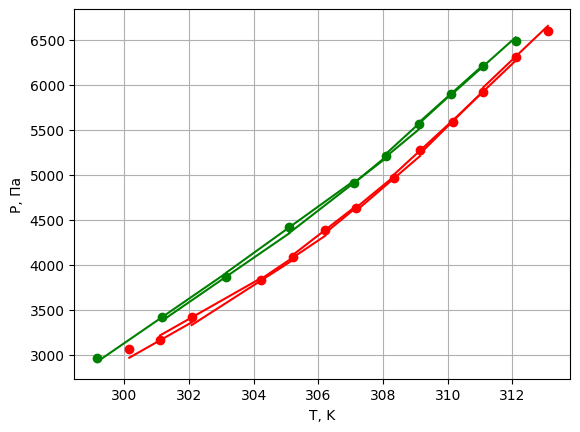

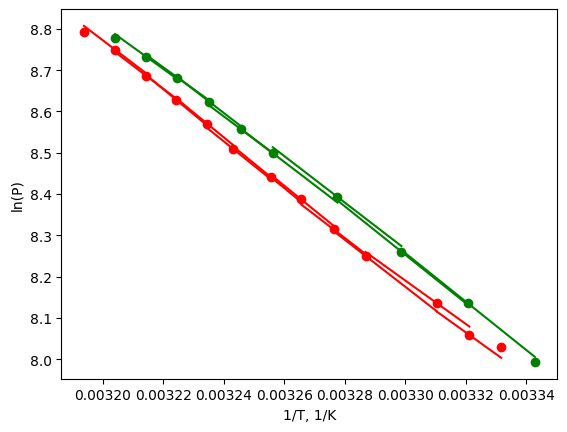

In [4]:
data = pd.read_csv("data.csv")
data["h1"] = data["h1"].apply(lambda x: DData(x,0.1,E=-3))
data["h2"] = data["h2"].apply(lambda x: DData(x,0.1,E=-3))
data["T"] = data["T0"].apply(lambda x: 273.15 + DData(x, 0.02))
data["h"] = data["h1"]-data["h2"]
data["P"] = data["h"] * 9.81 * DData(13600, 50)
DData.changeEInSerias(data["P"],0)
d_up = T_UP(data)
d_down = T_DOWN(data)[1:]
d_down.index = range(len(d_down))

def calc_func(xs, ys, col1 = "r", col2 = "r"):
    plt.plot(get_values(xs), get_values(ys), f"{col1}o")
    dets_ddata = calc_det(xs, ys)
    dets = get_values(dets_ddata)
    TS = xs
    PS = ys
    for i in range(1, len(xs)-1):
        k = dets[i]
        t_ss = TS[i-1:i+2]
        p_ss = [(TS[i-1]-TS[i])*k + PS[i], (TS[i]-TS[i])*k + PS[i], (TS[i+1]-TS[i])*k + PS[i]]
        plt.plot(get_values(t_ss), get_values(p_ss), col2)
    return dets_ddata
plt.grid(True)
plt.xlabel("T, K")
plt.ylabel("P, Па")
dets1 = calc_func(d_up["T"], d_up["P"], "r", "r")
dets2 = calc_func(d_down["T"], d_down["P"], "g", "g")
data["k1"] = pd.Series(dets1+dets2)
plt.savefig("graph1.png", dpi=300)
plt.figure()
plt.xlabel("1/T, 1/K")
plt.ylabel("ln(P)")
dets1 = calc_func(1/d_up["T"], np.log(d_up["P"]), "r", "r")
dets2 = calc_func(1/d_down["T"], np.log(d_down["P"]), "g", "g")
plt.savefig("graph2.png", dpi=300)
print(dets1)
data["k2"] = pd.Series(dets1+dets2)
data["L1"] = 8.31*data["T"]**2/data["P"]*data["k1"]/0.018
#data["L1"] = data["L1"].apply(lambda x: DData(x, epsilon=(x.epsilon**2 + 0.04**2)**0.5))
data["L2"] = -8.31*data["k2"]/0.018
#data["L2"] = data["L2"].apply(lambda x: DData(x, epsilon=(x.epsilon**2 + 0.04**2)**0.5))
DData.changeEInSerias(data["P"],3)
DData.changeEInSerias(data["k2"],3)
DData.changeEInSerias(data["L1"],6)
DData.changeEInSerias(data["L2"],6)


data


In [5]:
data_raw = pd.DataFrame()
data_raw["T, °C"] = data["T0"]
data_raw["$h_1$, мм"] = data["h1"]
data_raw["$h_2$, мм"] = data["h2"]


data_raw.to_clipboard()

In [6]:
data_calc = pd.DataFrame()
data_calc["T, °C"] = data["T0"]
data_calc["h, мм"] = data["h"]
data_calc["P, Па"] = data["P"]
data_calc["$\\frac{dP}{dT}$, Па/К"] = data["k1"]
data_calc["$\\frac{d(ln(P))}{d(1/T)}$, К"] = data["k2"]
data_calc["$L_1$, МДж/кг"] = data["L1"]
data_calc["$L_2$, МДж/кг"] = data["L2"]
data_calc["$\\epsilon_1$, %"] = data["L1"].apply(lambda x: int(np.round(x.epsilon*100)))
data_calc["$\\epsilon_2$, %"] = data["L2"].apply(lambda x: int(np.round(x.epsilon*100)))
DData.changeEInSerias(data_calc["P, Па"],0)

data_calc.to_clipboard()

data_calc

,"T, °C","h, мм","P, Па","$\frac{dP}{dT}$, Па/К","$\frac{d(ln(P))}{d(1/T)}$, К","$L_1$, МДж/кг","$L_2$, МДж/кг","$\epsilon_1$, %","$\epsilon_2$, %"
0,27.00,$23.00 \pm 0.14$,$3069 \pm 22$,$203 \pm 11$,$-5.26 \pm 0.25$,$2.76 \pm 0.15$,$2.43 \pm 0.11$,5,5
1,27.95,$23.70 \pm 0.14$,$3162 \pm 22$,$203 \pm 11$,$-5.26 \pm 0.25$,$2.69 \pm 0.15$,$2.43 \pm 0.11$,5,5
2,28.93,$25.60 \pm 0.14$,$3415 \pm 23$,$203 \pm 11$,$-5.26 \pm 0.25$,$2.51 \pm 0.14$,$2.43 \pm 0.11$,5,5
3,31.09,$28.70 \pm 0.14$,$3829 \pm 24$,$231 \pm 11$,$-5.70 \pm 0.21$,$2.57 \pm 0.13$,$2.631 \pm 0.097$,5,4
4,32.07,$30.60 \pm 0.14$,$4083 \pm 24$,$242 \pm 15$,$-5.64 \pm 0.22$,$2.55 \pm 0.15$,$2.60 \pm 0.10$,6,4
5,33.07,$32.90 \pm 0.14$,$4389 \pm 25$,$277.3 \pm 3.9$,$-5.95 \pm 0.15$,$2.735 \pm 0.041$,$2.747 \pm 0.071$,2,3
6,34.00,$34.70 \pm 0.14$,$4630 \pm 25$,$295 \pm 10$,$-5.97 \pm 0.17$,$2.771 \pm 0.097$,$2.758 \pm 0.077$,4,3
7,35.20,$37.20 \pm 0.14$,$4963 \pm 26$,$308 \pm 12$,$-5.89 \pm 0.15$,$2.72 \pm 0.11$,$2.721 \pm 0.070$,4,3
8,36.00,$39.50 \pm 0.14$,$5270 \pm 27$,$330.6 \pm 9.0$,$-6.02 \pm 0.13$,$2.768 \pm 0.077$,$2.779 \pm 0.058$,3,2
9,37.00,$41.90 \pm 0.14$,$5590 \pm 28$,$354.3 \pm 6.5$,$-6.08 \pm 0.12$,$2.815 \pm 0.054$,$2.805 \pm 0.056$,2,2


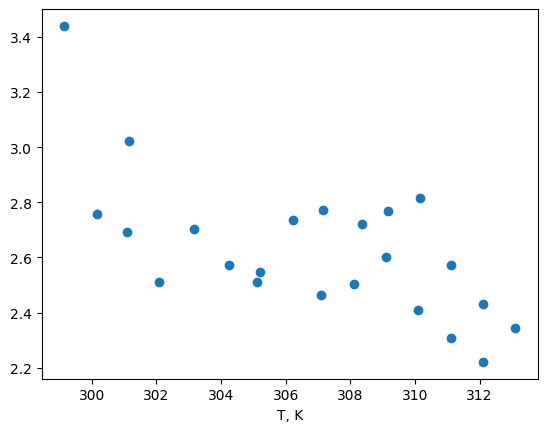

In [7]:
plt.xlabel("T, K")
plt.plot(get_values(data["T"]), get_values(data["L1"]),"o")

In [11]:
print(SerDData(data["L1"]).mean, SerDData(data["L2"]).mean)

$2.627 \pm 0.095$ $2.602 \pm 0.086$
